In [115]:
# 📦 Стандартные библиотеки
import os
import json
import random

# 📊 Обработка и визуализация данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 🤖 Машинное обучение
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 🔥 PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ⏳ Прогресс-бар
from tqdm import tqdm


In [116]:
# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🛠 Device: {device}")

# ----------------------------
# Paths setup
# ----------------------------
# DATA_PATH = "/kaggle/input/windloading-train/WindLoading_Train.csv"
# SAVE_ROOT = "/kaggle/working"

SAVE_ROOT = "/mnt/d/projects/wind_pressure_prediction_CNN/experiments"
DATA_ROOT = "/mnt/d/projects/wind_pressure_prediction_CNN"

TUNING_DIR = os.path.join(SAVE_ROOT, "tuning_CNN")  # адаптируй для CNN при необходимости
LOG_CSV_PATH = os.path.join(SAVE_ROOT, "experiments_log.csv")

os.makedirs(TUNING_DIR, exist_ok=True)

# ----------------------------
# Function to create a run-specific directory
# ----------------------------
def create_run_directory(
    run_name="cnn", lr=1e-3, batch_size=64, epochs=500,
    activation_fn=None, optimizer_name=None, base_dir=TUNING_DIR
):
    run_id = f"{run_name}_{lr:.0e}lr_{batch_size}bs_{epochs}ep"
    
    if activation_fn is not None:
        run_id += f"_{activation_fn.__name__}"
    if optimizer_name is not None:
        run_id += f"_{optimizer_name}"

    run_dir = os.path.join(base_dir, run_id)
    os.makedirs(run_dir, exist_ok=True)
    print(f"📂 Created run directory: {run_dir}")
    
    return run_id, run_dir


🛠 Device: cpu


In [117]:
# ➤ Класс CNN-модели
class WindPressureCNN(nn.Module):
    def __init__(self, input_channels, filters, activation_fn, use_batchnorm):
        super(WindPressureCNN, self).__init__()

        layers = []
        in_channels = input_channels
        for out_channels in filters:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation_fn())
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Conv2d(filters[-1], filters[-2], kernel_size=3, padding=1),
            activation_fn(),
            nn.Conv2d(filters[-2], 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [118]:
# ➤ Пользовательский Dataset
class WindGridDataset(Dataset):
    def __init__(self, X_tensor, Y_tensor):
        self.X = X_tensor
        self.Y = Y_tensor

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# ➤ Оценка
def evaluate_regression(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy().reshape(-1)
    y_pred = y_pred.detach().cpu().numpy().reshape(-1)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return {
        "MSE": mean_squared_error(y_true[mask], y_pred[mask]),
        "MAE": mean_absolute_error(y_true[mask], y_pred[mask]),
        "R2": r2_score(y_true[mask], y_pred[mask])
    }

# ➤ Основная функция
def train_cnn(
    lr,
    batch_size,
    epochs,
    input_channels,
    activation_fn,
    optimizer_name,
    loss_fn,
    filters,
    use_batchnorm
    ):
    # Загружаем данные
    X_all = np.load(os.path.join(
    DATA_ROOT, "data", "processed", "cnn_input", "X_cnn.npy"
    ))
    Y_all = np.load(os.path.join(
    DATA_ROOT, "data", "processed", "cnn_input", "Y_cnn.npy"
    ))

    X_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)
    Y_tensor = torch.tensor(Y_all, dtype=torch.float32).to(device)
    print("X_all shape:", X_all.shape)
    print("Y_all shape:", Y_all.shape)

    n_splits = 2
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
        print(f"\n🔁 Fold {fold + 1} / {n_splits}")

        model = WindPressureCNN(
            input_channels=input_channels,
            filters=filters,
            activation_fn=activation_fn,
            use_batchnorm=use_batchnorm
        ).to(device)

        # Инициализируем функцию потерь
        criterion = loss_fn()

        # Инициализируем оптимизатор
        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")

        # Датасеты и загрузчики
        train_dataset = WindGridDataset(X_tensor[train_idx], Y_tensor[train_idx])
        val_dataset   = WindGridDataset(X_tensor[val_idx],   Y_tensor[val_idx])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset, batch_size=batch_size)

        best_loss = float("inf")
        patience = 100
        counter = 0

        for epoch in tqdm(range(epochs), desc="Epochs"):
            model.train()
            epoch_loss = 0.0
            for batch_X, batch_Y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            # ➤ Оцениваем метрики каждые 20 эпох
            if (epoch + 1) % 20 == 0 or epoch == 0 or epoch == epochs - 1:
                model.eval()
                with torch.no_grad():
                    y_val_pred = model(X_tensor[val_idx])
                    epoch_metrics = evaluate_regression(Y_tensor[val_idx], y_val_pred)
                    print(f"📉 Epoch {epoch + 1} | Train Loss: {epoch_loss:.6f} | "
                        f"Val R2: {epoch_metrics['R2']:.4f} | "
                        f"MAE: {epoch_metrics['MAE']:.4f} | "
                        f"MSE: {epoch_metrics['MSE']:.6f}")


            # Early stopping
            val_loss = 0.0
            model.eval()
            with torch.no_grad():
                for batch_X, batch_Y in val_loader:
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_Y)
                    val_loss += loss.item()

            if val_loss < best_loss:
                best_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print("⏹️ Early stopping")
                    break

        # ➤ Оценка на валидации
        model.eval()
        with torch.no_grad():
            y_pred = model(X_tensor[val_idx])
            metrics = evaluate_regression(Y_tensor[val_idx], y_pred)
            fold_metrics.append(metrics)
            print(f"📈 Fold {fold + 1} metrics:", metrics)

    # ➤ Средние метрики
    avg_metrics = {
        "MSE": np.mean([m["MSE"] for m in fold_metrics]),
        "MAE": np.mean([m["MAE"] for m in fold_metrics]),
        "R2":  np.mean([m["R2"]  for m in fold_metrics]),
    }

    # ➤ Сохраняем конфиг и лог
    run_id, run_dir = create_run_directory(run_name="cnn", lr=lr, batch_size=batch_size, epochs=epochs)
    config = {
    "model": "CNN",
    "lr": lr,
    "batch_size": batch_size,
    "epochs": epochs,
    "input_channels": input_channels,
    "activation_fn": activation_fn.__name__,
    "optimizer": optimizer_name,
    "loss_fn": loss_fn.__name__,
    "filters": filters,
    "batchnorm": use_batchnorm,
    "target_shape": "1x9x28"
    }

    # ➤ Путь к директории для лучшей модели
    BEST_MODEL_DIR = os.path.join(SAVE_ROOT, "best_model")
    os.makedirs(BEST_MODEL_DIR, exist_ok=True)  # создаём, если нет

    # ➤ Полный путь к файлу весов
    MODEL_SAVE_PATH = os.path.join(BEST_MODEL_DIR, f"best_{run_id}.pth")

    # ➤ Сохраняем веса модели, если R² выше порога
    if avg_metrics["R2"] > 0.2:
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"💾 Saved best model weights to {MODEL_SAVE_PATH}")


    with open(os.path.join(run_dir, f"config_{run_id}.json"), "w") as f:
        json.dump(config, f, indent=4)

    log_header = "run_id,model,lr,batch_size,activation_fn,optimizer,R2,MAE,MSE\n"
    log_line = (
    f"{run_id},cnn,{lr:.0e},{batch_size},"
    f"{activation_fn.__name__},{optimizer_name},"
    f"{float(avg_metrics['R2']):.4f},"
    f"{float(avg_metrics['MAE']):.4f},"
    f"{float(avg_metrics['MSE']):.6f}\n"
    )


    write_header = not os.path.exists(LOG_CSV_PATH)

    with open(LOG_CSV_PATH, "a") as f:
        if write_header:
            f.write(log_header)
        f.write(log_line)
    

    print("\n📊 Avg Metrics across 5 folds:", {
    "MSE": float(avg_metrics["MSE"]),
    "MAE": float(avg_metrics["MAE"]),
    "R2":  float(avg_metrics["R2"])
    })
    return run_id, avg_metrics


In [119]:
# 📁 src/train/train_cnn_random_search.py


# ----------------------------
# Гиперпараметры для Random Search
# ----------------------------
lr_choices = [0.003]                # 🔧 Скорость обучения (learning rate)
batch_size_choices = [64]                 # 📦 Размер мини-батча
epoch_choices = [1000]                   # 🔁 Количество эпох обучения

activation_choices = [
    nn.ReLU,
    nn.Tanh,
    nn.Sigmoid,
    nn.LeakyReLU,
    nn.ELU,
    nn.SELU,
    nn.GELU,
]   
                                               # ⚡️ Функция активации для нейронов
optimizer_choices = ["Adam"]                        # 🧠 Оптимизатор (метод обновления весов)
loss_fn_choices = [nn.MSELoss]                      # 📉 Функция потерь (для оценки ошибки)

filters_choices = [
    [16, 32, 64],                                 # 🧱 Конфигурация свёрточных фильтров (кол-во каналов на каждом слое)
    ]

batchnorm_choices = [True]                 # ✅ Использовать ли BatchNorm после Conv-слоёв


N_RUNS = 5  # Количество запусков

# ----------------------------
# Random Search Loop
# ----------------------------
for run in range(N_RUNS):
    lr = random.choice(lr_choices)
    batch_size = random.choice(batch_size_choices)
    epochs = random.choice(epoch_choices)
    activation_fn = random.choice(activation_choices)
    optimizer_name = random.choice(optimizer_choices)
    loss_fn = random.choice(loss_fn_choices)
    filters = random.choice(filters_choices)
    use_batchnorm = random.choice(batchnorm_choices)

    print(f"\n🔁 Run {run + 1}/{N_RUNS}")
    print(f"→ lr: {lr}, batch_size: {batch_size}, epochs: {epochs}")
    print(f"→ activation: {activation_fn.__name__}, optimizer: {optimizer_name}, loss_fn: {loss_fn.__name__}")
    print(f"→ filters: {filters}, batchnorm: {use_batchnorm}")

    run_id, metrics = train_cnn(
        lr=lr,
        batch_size=batch_size,
        epochs=epochs,
        input_channels=3,
        activation_fn=activation_fn,
        optimizer_name=optimizer_name,
        loss_fn=loss_fn,
        filters=filters,
        use_batchnorm=use_batchnorm
    )

    print(f"✅ Finished run {run_id}")
    print(f"📊 Metrics: {{'MSE': {float(metrics['MSE']):.6f}, 'MAE': {float(metrics['MAE']):.6f}, 'R2': {float(metrics['R2']):.4f}}}")



🔁 Run 1/5
→ lr: 0.003, batch_size: 64, epochs: 1000
→ activation: Tanh, optimizer: Adam, loss_fn: MSELoss
→ filters: [16, 32, 64], batchnorm: True
X_all shape: (608, 3, 9, 28)
Y_all shape: (608, 1, 9, 28)

🔁 Fold 1 / 2


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

📉 Epoch 1 | Train Loss: 3.055838 | Val R2: -0.0888 | MAE: 0.4232 | MSE: 0.270306


Epochs:   2%|▏         | 19/1000 [00:14<13:20,  1.23it/s]

📉 Epoch 20 | Train Loss: 1.004255 | Val R2: 0.1702 | MAE: 0.3557 | MSE: 0.206006


Epochs:   4%|▍         | 40/1000 [00:27<08:47,  1.82it/s]

📉 Epoch 40 | Train Loss: 0.955709 | Val R2: 0.2291 | MAE: 0.3401 | MSE: 0.191392


Epochs:   6%|▌         | 60/1000 [00:37<08:37,  1.82it/s]

📉 Epoch 60 | Train Loss: 0.938067 | Val R2: 0.2384 | MAE: 0.3267 | MSE: 0.189064


Epochs:   8%|▊         | 80/1000 [00:48<08:14,  1.86it/s]

📉 Epoch 80 | Train Loss: 0.953705 | Val R2: 0.2359 | MAE: 0.3257 | MSE: 0.189697


Epochs:  10%|█         | 100/1000 [00:59<09:49,  1.53it/s]

📉 Epoch 100 | Train Loss: 0.940420 | Val R2: 0.2447 | MAE: 0.3308 | MSE: 0.187505


Epochs:  12%|█▏        | 120/1000 [01:10<09:06,  1.61it/s]

📉 Epoch 120 | Train Loss: 0.933339 | Val R2: 0.2486 | MAE: 0.3230 | MSE: 0.186551


Epochs:  13%|█▎        | 127/1000 [01:16<08:43,  1.67it/s]


KeyboardInterrupt: 

📊 Total CNN runs: 2


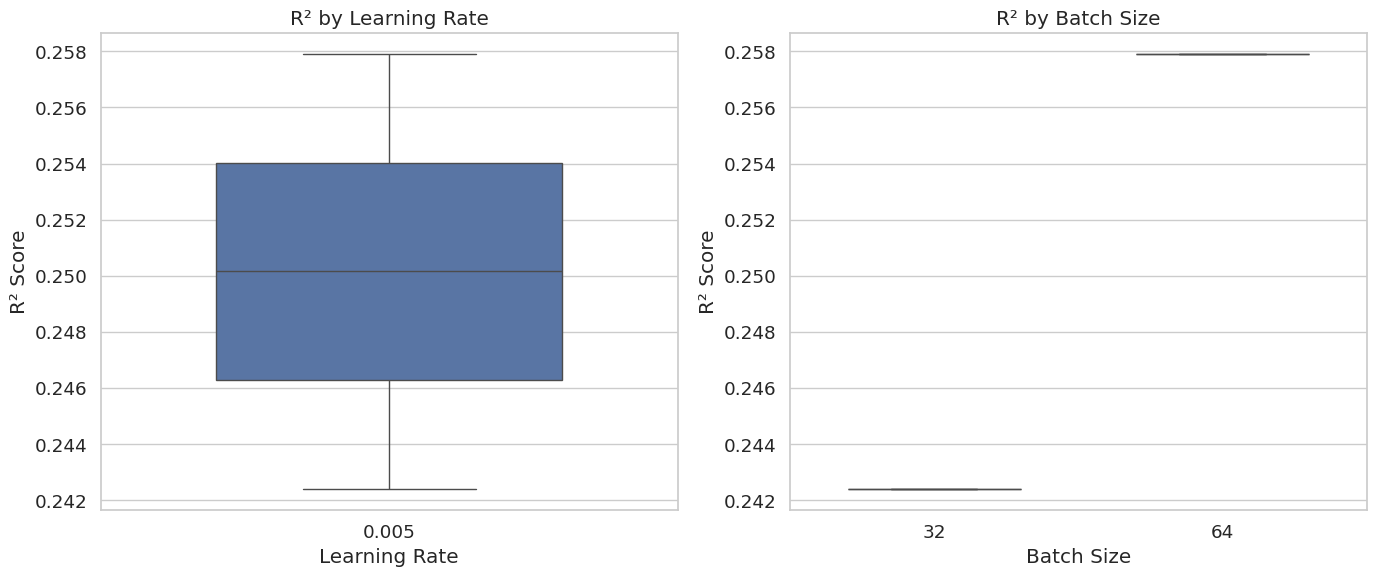

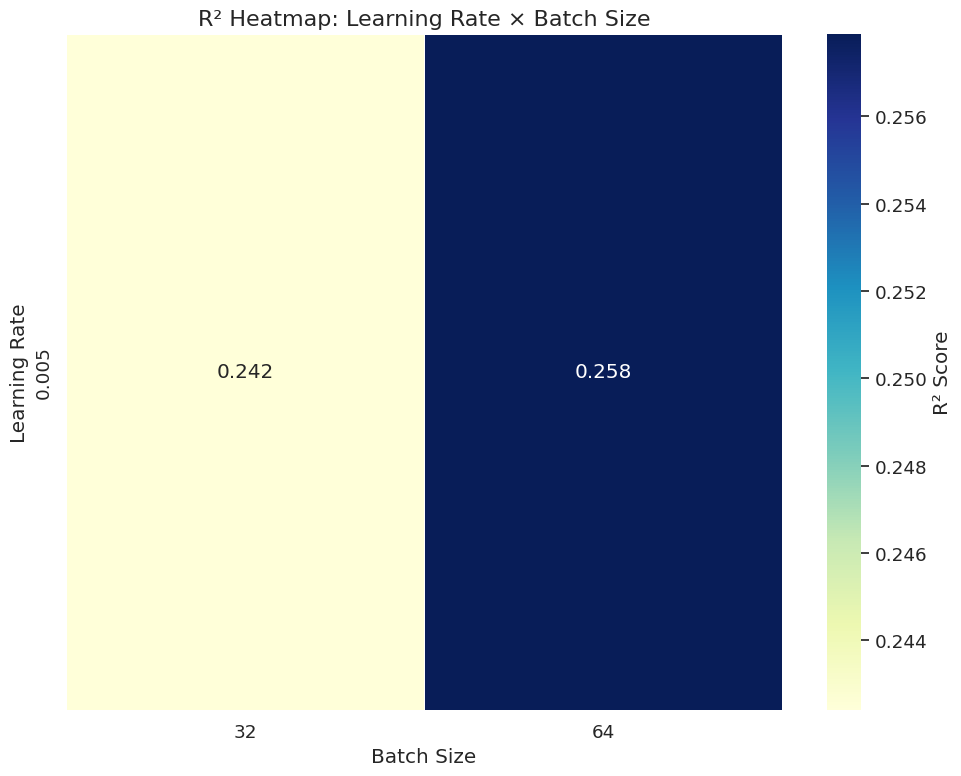


📌 Best R²: 0.2579
📉 Threshold (95%): 0.2450
🧱 Stable CNN configs: 1

                    run_id     lr  batch_size      R2    MAE       MSE
0  cnn_5e-03lr_64bs_1000ep  0.005          64  0.2579  0.316  0.183937


In [ ]:
# 🔄 Путь к логу (можно поменять на нужный)
LOG_CSV_PATH = os.path.join(DATA_ROOT, "experiments", "experiments_log.csv")
df_log = pd.read_csv(LOG_CSV_PATH)


# 🎨 Стиль графиков
sns.set(style="whitegrid", palette="deep", font_scale=1.2)

# ➤ Фильтруем только CNN
df_cnn = df_log[df_log["run_id"].str.startswith("cnn")].copy()
print(f"📊 Total CNN runs: {len(df_cnn)}")

# ------------------------------
# 📈 Boxplot: R² по lr и batch_size
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 📌 Boxplot: Learning Rate
sns.boxplot(x="lr", y="R2", data=df_cnn, ax=axes[0], width=0.6)
axes[0].set_title("R² by Learning Rate")
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("R² Score")

# 📌 Boxplot: Batch Size
sns.boxplot(x="batch_size", y="R2", data=df_cnn, ax=axes[1], width=0.6)
axes[1].set_title("R² by Batch Size")
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("R² Score")

plt.tight_layout()
plt.show()

# ------------------------------
# 🔥 Heatmap: R² по lr × batch_size
# ------------------------------
pivot = df_cnn.pivot_table(
    values="R2",
    index="lr",
    columns="batch_size",
    aggfunc="mean"
).sort_index(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "R² Score"})
plt.title("R² Heatmap: Learning Rate × Batch Size", fontsize=16)
plt.xlabel("Batch Size")
plt.ylabel("Learning Rate")
plt.tight_layout()
plt.show()

# ------------------------------
# ⭐ Лучшие конфигурации
# ------------------------------
r2_max = df_cnn["R2"].max()
threshold = r2_max * 0.95
stable = df_cnn[df_cnn["R2"] >= threshold]

print(f"\n📌 Best R²: {r2_max:.4f}")
print(f"📉 Threshold (95%): {threshold:.4f}")
print(f"🧱 Stable CNN configs: {len(stable)}\n")
print(stable.sort_values("R2", ascending=False)[["run_id", "lr", "batch_size", "R2", "MAE", "MSE"]])


✅ Модель успешно восстановлена и готова к использованию.
📦 Загружены данные:
X_all: (608, 3, 9, 28)
Y_all: (608, 1, 9, 28)


/tmp/ipykernel_645/397146551.py:74: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_645/397146551.py:74: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


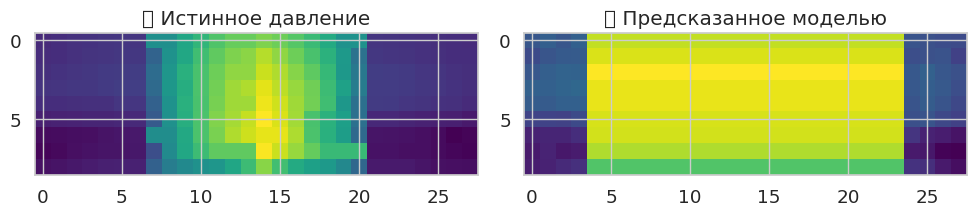

In [ ]:
# ➤ Класс CNN-модели (предполагаем, что он уже определён выше)
# class WindPressureCNN(nn.Module): ...

# 📍 Укажи путь к конфигу и весам
CONFIG_PATH = "/mnt/d/projects/wind_pressure_prediction_CNN/experiments/tuning_CNN/cnn_5e-03lr_32bs_1000ep/config_cnn_5e-03lr_32bs_1000ep.json"
MODEL_SAVE_PATH = "/mnt/d/projects/wind_pressure_prediction_CNN/experiments/best_model/best_cnn_5e-03lr_32bs_1000ep.pth"

# ➤ Загружаем конфиг
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

# ➤ Преобразуем имя функции активации в класс
activation_map = {
    "ReLU": nn.ReLU,
    "Tanh": nn.Tanh,
    "Sigmoid": nn.Sigmoid,
    "LeakyReLU": nn.LeakyReLU,
    "ELU": nn.ELU,
    "SELU": nn.SELU,
    "GELU": nn.GELU
}


activation_fn = activation_map[config["activation_fn"]]

# ➤ Воссоздаём модель
model = WindPressureCNN(
    input_channels=config["input_channels"],
    filters=config["filters"],
    activation_fn=activation_fn,
    use_batchnorm=config["batchnorm"]
)

# ➤ Загружаем веса
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()  # переводим в режим оценки

print("✅ Модель успешно восстановлена и готова к использованию.")

# ➤ Путь к данным
X_PATH = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input/X_cnn.npy"
Y_PATH = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input/Y_cnn.npy"

# ➤ Загрузка данных
X_all = np.load(X_PATH)
Y_all = np.load(Y_PATH)

print("📦 Загружены данные:")
print("X_all:", X_all.shape)
print("Y_all:", Y_all.shape)

# ➤ Выбор случайного примера
idx = random.randint(0, len(X_all) - 1)
X_sample = torch.tensor(X_all[idx:idx+1], dtype=torch.float32)  # shape: [1, C, H, W]
Y_true = Y_all[idx]  # shape: [1, H, W] или [H, W]

# ➤ Предсказание модели
with torch.no_grad():
    Y_pred = model(X_sample).squeeze().cpu().numpy()

# ➤ Визуализация
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(Y_true.squeeze(), cmap='viridis')
axs[0].set_title("🎯 Истинное давление")

axs[1].imshow(Y_pred.squeeze(), cmap='viridis')
axs[1].set_title("🔮 Предсказанное моделью")

plt.tight_layout()
plt.show()
